In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
mat3 = loadmat("ex8_movies.mat")
mat4 = loadmat("ex8_movieParams.mat")
Y = mat3["Y"] # 1682 X 943 matrix, containing ratings (1-5) of 1682 movies on 943 user
R = mat3["R"] # 1682 X 943 matrix, where R(i,j) = 1 if and only if user j give rating to movie i
X = mat4["X"] # 1682 X 10 matrix , num_movies X num_features matrix of movie features
Theta = mat4["Theta"] # 943 X 10 matrix, num_users X num_features matrix of user features
# Compute average rating 
print("Average rating for movie 1 (Toy Story):",np.sum(Y[0,:]*R[0,:])/np.sum(R[0,:]),"/5")

Average rating for movie 1 (Toy Story): 3.8783185840707963 /5


Text(0, 0.5, 'Movies')

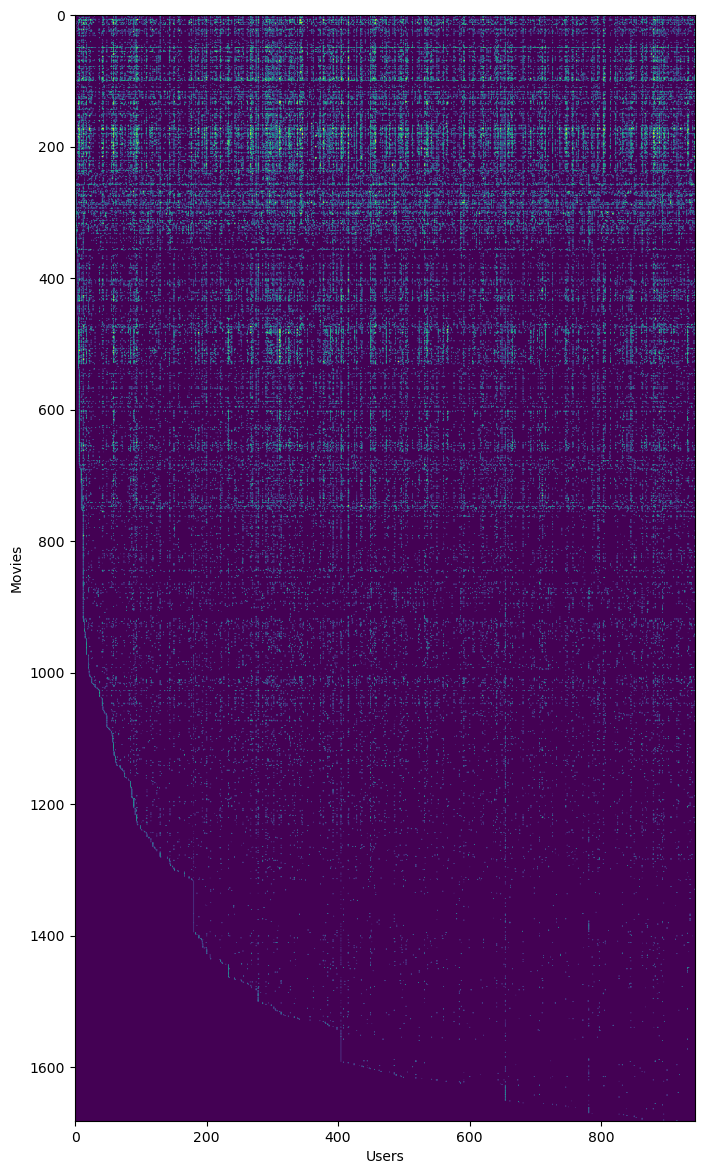

In [5]:
plt.figure(figsize=(8,16))
plt.imshow(Y)
plt.xlabel("Users")
plt.ylabel("Movies")

In [6]:
def  cofiCostFunc(params, Y, R, num_users, num_movies, num_features, Lambda):
    """
    Returns the cost and gradient for the collaborative filtering problem
    """
    
    # Unfold the params
    X = params[:num_movies*num_features].reshape(num_movies,num_features)
    Theta = params[num_movies*num_features:].reshape(num_users,num_features)
    
    predictions =  X @ Theta.T
    err = (predictions - Y)
    J = 1/2 * np.sum((err**2) * R)
    
    #compute regularized cost function
    reg_X =  Lambda/2 * np.sum(Theta**2)
    reg_Theta = Lambda/2 *np.sum(X**2)
    reg_J = J + reg_X + reg_Theta
    
    # Compute gradient
    X_grad = err*R @ Theta
    Theta_grad = (err*R).T @ X
    grad = np.append(X_grad.flatten(),Theta_grad.flatten())
    
    # Compute regularized gradient
    reg_X_grad = X_grad + Lambda*X
    reg_Theta_grad = Theta_grad + Lambda*Theta
    reg_grad = np.append(reg_X_grad.flatten(),reg_Theta_grad.flatten())
    
    return J, grad, reg_J, reg_grad

In [7]:
# Reduce the data set size to run faster
num_users, num_movies, num_features = 4,5,3
X_test = X[:num_movies,:num_features]
Theta_test= Theta[:num_users,:num_features]
Y_test = Y[:num_movies,:num_users]
R_test = R[:num_movies,:num_users]
params = np.append(X_test.flatten(),Theta_test.flatten())
# Evaluate cost function
J, grad = cofiCostFunc(params, Y_test, R_test, num_users, num_movies, num_features, 0)[:2]
print("Cost at loaded parameters:",J)
J2, grad2 = cofiCostFunc(params, Y_test, R_test, num_users, num_movies, num_features, 1.5)[2:]
print("Cost at loaded parameters (lambda = 1.5):",J2)

Cost at loaded parameters: 22.224603725685675
Cost at loaded parameters (lambda = 1.5): 31.34405624427422


In [8]:
# load movie list
movieList = open("movie_ids.txt","r").read().split("\n")[:-1]

movieList

['1 Toy Story (1995)',
 '2 GoldenEye (1995)',
 '3 Four Rooms (1995)',
 '4 Get Shorty (1995)',
 '5 Copycat (1995)',
 '6 Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)',
 '7 Twelve Monkeys (1995)',
 '8 Babe (1995)',
 '9 Dead Man Walking (1995)',
 '10 Richard III (1995)',
 '11 Seven (Se7en) (1995)',
 '12 Usual Suspects, The (1995)',
 '13 Mighty Aphrodite (1995)',
 '14 Postino, Il (1994)',
 "15 Mr. Holland's Opus (1995)",
 '16 French Twist (Gazon maudit) (1995)',
 '17 From Dusk Till Dawn (1996)',
 '18 White Balloon, The (1995)',
 "19 Antonia's Line (1995)",
 '20 Angels and Insects (1995)',
 '21 Muppet Treasure Island (1996)',
 '22 Braveheart (1995)',
 '23 Taxi Driver (1976)',
 '24 Rumble in the Bronx (1995)',
 '25 Birdcage, The (1996)',
 '26 Brothers McMullen, The (1995)',
 '27 Bad Boys (1995)',
 '28 Apollo 13 (1995)',
 '29 Batman Forever (1995)',
 '30 Belle de jour (1967)',
 '31 Crimson Tide (1995)',
 '32 Crumb (1994)',
 '33 Desperado (1995)',
 '34 Doom Generation, The (1995)',
 '35

In [9]:
# Initialize my ratings
my_ratings = np.zeros((1682,1))

In [10]:
def normalizeRatings(Y, R):
    """
    normalized Y so that each movie has a rating of 0 on average, and returns the mean rating in Ymean.
    """
    
    m,n = Y.shape[0], Y.shape[1]
    Ymean = np.zeros((m,1))
    Ynorm = np.zeros((m,n))
    
    for i in range(m):
        Ymean[i] = np.sum(Y[i,:])/np.count_nonzero(R[i,:])
        Ynorm[i,R[i,:]==1] = Y[i,R[i,:]==1] - Ymean[i]
        
    return Ynorm, Ymean
def gradientDescent(initial_parameters,Y,R,num_users,num_movies,num_features,alpha,num_iters,Lambda):
    """
    Optimize X and Theta
    """
    # unfold the parameters
    X = initial_parameters[:num_movies*num_features].reshape(num_movies,num_features)
    Theta = initial_parameters[num_movies*num_features:].reshape(num_users,num_features)
    
    J_history =[]
    
    for i in range(num_iters):
        params = np.append(X.flatten(),Theta.flatten())
        cost, grad = cofiCostFunc(params, Y, R, num_users, num_movies, num_features, Lambda)[2:]
        
        # unfold grad
        X_grad = grad[:num_movies*num_features].reshape(num_movies,num_features)
        Theta_grad = grad[num_movies*num_features:].reshape(num_users,num_features)
        X = X - (alpha * X_grad)
        Theta = Theta - (alpha * Theta_grad)
        J_history.append(cost)
    
    paramsFinal = np.append(X.flatten(),Theta.flatten())
    return paramsFinal , J_history

In [11]:
Y = np.hstack((my_ratings,Y))
R =np.hstack((my_ratings!=0,R))
# Normalize Ratings
Ynorm, Ymean = normalizeRatings(Y, R)
num_users = Y.shape[1]
num_movies = Y.shape[0]
num_features = 10
# Set initial Parameters (Theta,X)
X = np.random.randn(num_movies, num_features)
Theta = np.random.randn(num_users, num_features)
initial_parameters = np.append(X.flatten(),Theta.flatten())
Lambda = 10
# Optimize parameters using Gradient Descent
paramsFinal, J_history = gradientDescent(initial_parameters,Y,R,num_users,num_movies,num_features,0.001,400,Lambda)

Text(0.5, 1.0, 'Cost function using Gradient Descent')

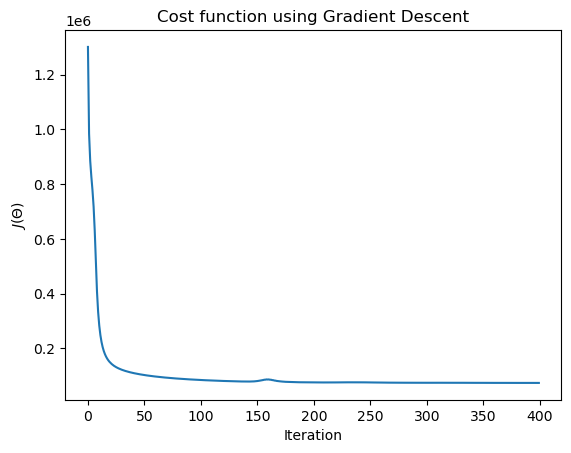

In [12]:
plt.plot(J_history)
plt.xlabel("Iteration")
plt.ylabel("$J(\Theta)$")
plt.title("Cost function using Gradient Descent")

In [13]:
# unfold paramaters
X = paramsFinal[:num_movies*num_features].reshape(num_movies,num_features)
Theta = paramsFinal[num_movies*num_features:].reshape(num_users,num_features)
# Predict rating
p = X @ Theta.T
my_predictions = p[:,0][:,np.newaxis] + Ymean
import pandas as pd
df = pd.DataFrame(np.hstack((my_predictions,np.array(movieList)[:,np.newaxis])))
df.sort_values(by=[0],ascending=False,inplace=True)
df.reset_index(drop=True,inplace=True)
print("Top recommendations for you:\n")
for i in range(10):
    print("Predicting rating",round(float(df[0][i]),1)," for index",df[1][i])

Top recommendations for you:

Predicting rating 5.0  for index 1467 Saint of Fort Washington, The (1993)
Predicting rating 5.0  for index 1653 Entertaining Angels: The Dorothy Day Story (1996)
Predicting rating 5.0  for index 1500 Santa with Muscles (1996)
Predicting rating 5.0  for index 1122 They Made Me a Criminal (1939)
Predicting rating 5.0  for index 1536 Aiqing wansui (1994)
Predicting rating 5.0  for index 1189 Prefontaine (1997)
Predicting rating 5.0  for index 1293 Star Kid (1997)
Predicting rating 5.0  for index 1599 Someone Else's America (1995)
Predicting rating 5.0  for index 1201 Marlene Dietrich: Shadow and Light (1996) 
Predicting rating 5.0  for index 814 Great Day in Harlem, A (1994)
